<a id='sectionb'></a>
## 1. Data Exploration

In this part, we will mainly examine the distributions and meanings of each variable at first. Then give decisions about feature selection and missing value imputation techniques to create a sufficient data for the modeling part.

In [1]:
# Import needed packages for the data exploration stage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn import preprocessing
from PIL import Image

pd.set_option('display.max_columns', None)

In [2]:
csv = '.\data\custom\rawdata.csv' # Assign the name of the csv file.
dataframe = pd.read_csv(csv, sep=";") # Read the csv file.
dataframe.head() # Inspect the raw data.

,Ax,Ay,Az,Gx,Gy,Gz,Room,"Obj,,"
0,3692,-3452,15500,-111,-258,-43,"32,47","24,71"
1,3748,-3468,15428,-31,-176,-72,"32,29","24,71"
2,3952,-3208,15196,36,-436,-120,"32,17","24,27"
3,4084,-3228,15380,-341,-190,-74,"32,11","26,43"
4,4304,-3132,15360,-580,-200,29,"32,03","29,19"


In [3]:
dataframe.describe()

,Ax,Ay,Az,Gx,Gy
count,472.000000,472.000000,472.000000,472.000000,4.720000e+02
mean,9764.542373,-2314.983051,10634.127119,-228.796610,2.568729e+04
std,5339.093567,850.869389,4605.279140,1574.993154,5.598400e+05
min,3436.000000,-5768.000000,4988.000000,-7333.000000,-1.018100e+04
25%,4267.000000,-2955.000000,5944.000000,-559.750000,-3.412500e+02
50%,12622.000000,-2118.000000,9364.000000,-313.500000,-1.000000e+00
75%,15126.000000,-1660.000000,15308.000000,-68.750000,2.982500e+02
max,16172.000000,312.000000,16076.000000,31153.000000,1.216274e+07


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ax      472 non-null    int64 
 1   Ay      472 non-null    int64 
 2   Az      472 non-null    int64 
 3   Gx      472 non-null    int64 
 4   Gy      472 non-null    int64 
 5   Gz      472 non-null    object
 6   Room    472 non-null    object
 7   Obj,,   471 non-null    object
dtypes: int64(5), object(3)
memory usage: 29.6+ KB


In [5]:
import plotly.graph_objects as go
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import peak_prominences


time_series = dataframe['Ax']

#indices = find_peaks(time_series,distance=6, )[0]
indices = find_peaks(time_series,prominence=400 )[0]


fig = go.Figure()
fig.add_trace(go.Scatter(
    y=time_series,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()

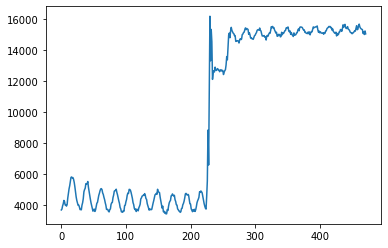

In [6]:
dataframe['Ax'].plot.line()

In [72]:
import cv2
import numpy as np

filename = './data/image.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.05*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

cv2.imwrite('subpixel5.png',img)


True

In [7]:
# Import needed packages for the model building stage
import numpy as np
import pandas as pd
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn_extra.cluster import KMedoids

In [8]:
class CustomTabularDataset(Dataset):
    def __init__(self, data, seq_length, step_size):

        self.len = data.shape[0]
        self.seq_length = seq_length
        self.step_size = step_size
        self.X = data.to_numpy().astype(float)

    def __len__(self):
        return self.len - self.seq_length

    def __getitem__(self, idx):
        
        data=self.X[idx*self.step_size:idx*self.step_size+self.seq_length] ### Ahmet ### Take the input sequence 
        return data

In [9]:
#seq_length=80 ==> 14 saniyelik sinyal

dataset_train = CustomTabularDataset(data=dataframe['Ax'], seq_length=80, step_size=1)
                                                                                                   
dataloader_train = DataLoader(dataset_train, batch_size=1, 
                        shuffle=False, num_workers=0) # Dataloader for Training samples    

In [ ]:
idx=0
for data in dataloader_train:
    print_data = data.numpy()

    plt.figure(figsize=(4, 4),dpi=64)
    
    plt.plot(print_data[0], linewidth=6, color='black')
    plt.axis('off')
    istr = f'{idx}'
    #print('data'+ istr +'.png')
    plt.savefig('data'+istr+'.jpg')
    #plt.show()
    #Image.open('data'+istr+'.png').convert('L').save('data'+istr+'.png')
    idx+=1

[[15428. 15456. 15472. 15496. 15500. 15544. 15300. 15140. 15216. 15104.
  15168. 15104. 15080. 15076. 15112. 15012. 15112. 15068. 15220. 15232.
  15364. 15416. 15448. 15512. 15500. 15512. 15428. 15448. 15276. 15352.
  15188. 15148. 15080. 15084. 15144. 14904. 15064. 14968. 15012. 15160.
  15168. 15316. 15308. 15200. 15364. 15620. 15468. 15588. 15648. 15436.
  15380. 15404. 15504. 15340. 15316. 15264. 15156. 15116. 15108. 15044.
  15088. 15112. 15176. 15232. 15212. 15392. 15564. 15304. 15336. 15576.
  15664. 15488. 15404. 15360. 15332. 15308. 15064. 15156. 14996. 15224.]]
